In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 데이터 로딩
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

In [5]:
print(f"Train 데이터 크기: {train_data.shape}")
print(f"Test 데이터 크기: {test_data.shape}")
print(f"결측치 확인: {train_data.isnull().sum().sum()}")

Train 데이터 크기: (165034, 14)
Test 데이터 크기: (110023, 13)
결측치 확인: 0


In [6]:
# 기본 데이터 정보
print(train_data.head())
print(f"\n타겟 분포:\n{train_data['Exited'].value_counts(normalize=True)}")

   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1       0  
2       0  
3       0  
4 

### 데이터 설명
- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides
- Gender: The customer's gender
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card) / 고객이 사용하는 은행 상품 수(예: 저축 계좌, 신용 카드)
- HasCrCard: Whether the customer has a credit card
- IsActiveMember: Whether the customer is an active member
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (Target Variable)

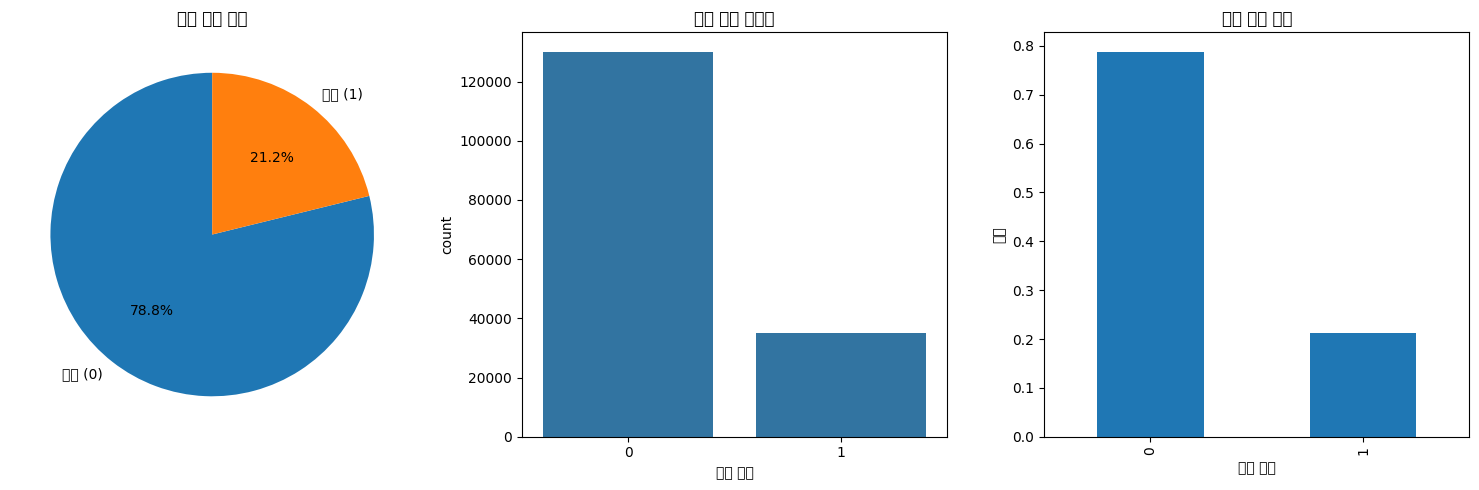

클래스 불균형 정도:
잔류 고객: 130,113명 (78.8%)
이탈 고객: 34,921명 (21.2%)


In [6]:
# EDA
# 1. 타겟 변수 분석
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
target_counts = train_data['Exited'].value_counts()
plt.pie(target_counts.values, labels=['잔류 (0)', '이탈 (1)'], autopct='%1.1f%%', startangle=90)
plt.title('타겟 변수 분포')

plt.subplot(1, 3, 2)
sns.countplot(data=train_data, x='Exited')
plt.title('타겟 변수 카운트')
plt.xlabel('이탈 여부')

plt.subplot(1, 3, 3)
train_data['Exited'].value_counts(normalize=True).plot(kind='bar')
plt.title('타겟 변수 비율')
plt.xlabel('이탈 여부')
plt.ylabel('비율')

plt.tight_layout()
plt.show()

print(f"클래스 불균형 정도:")
print(f"잔류 고객: {train_data['Exited'].value_counts()[0]:,}명 ({train_data['Exited'].value_counts(normalize=True)[0]:.1%})")
print(f"이탈 고객: {train_data['Exited'].value_counts()[1]:,}명 ({train_data['Exited'].value_counts(normalize=True)[1]:.1%})")


=== 수치형 변수 분석 ===


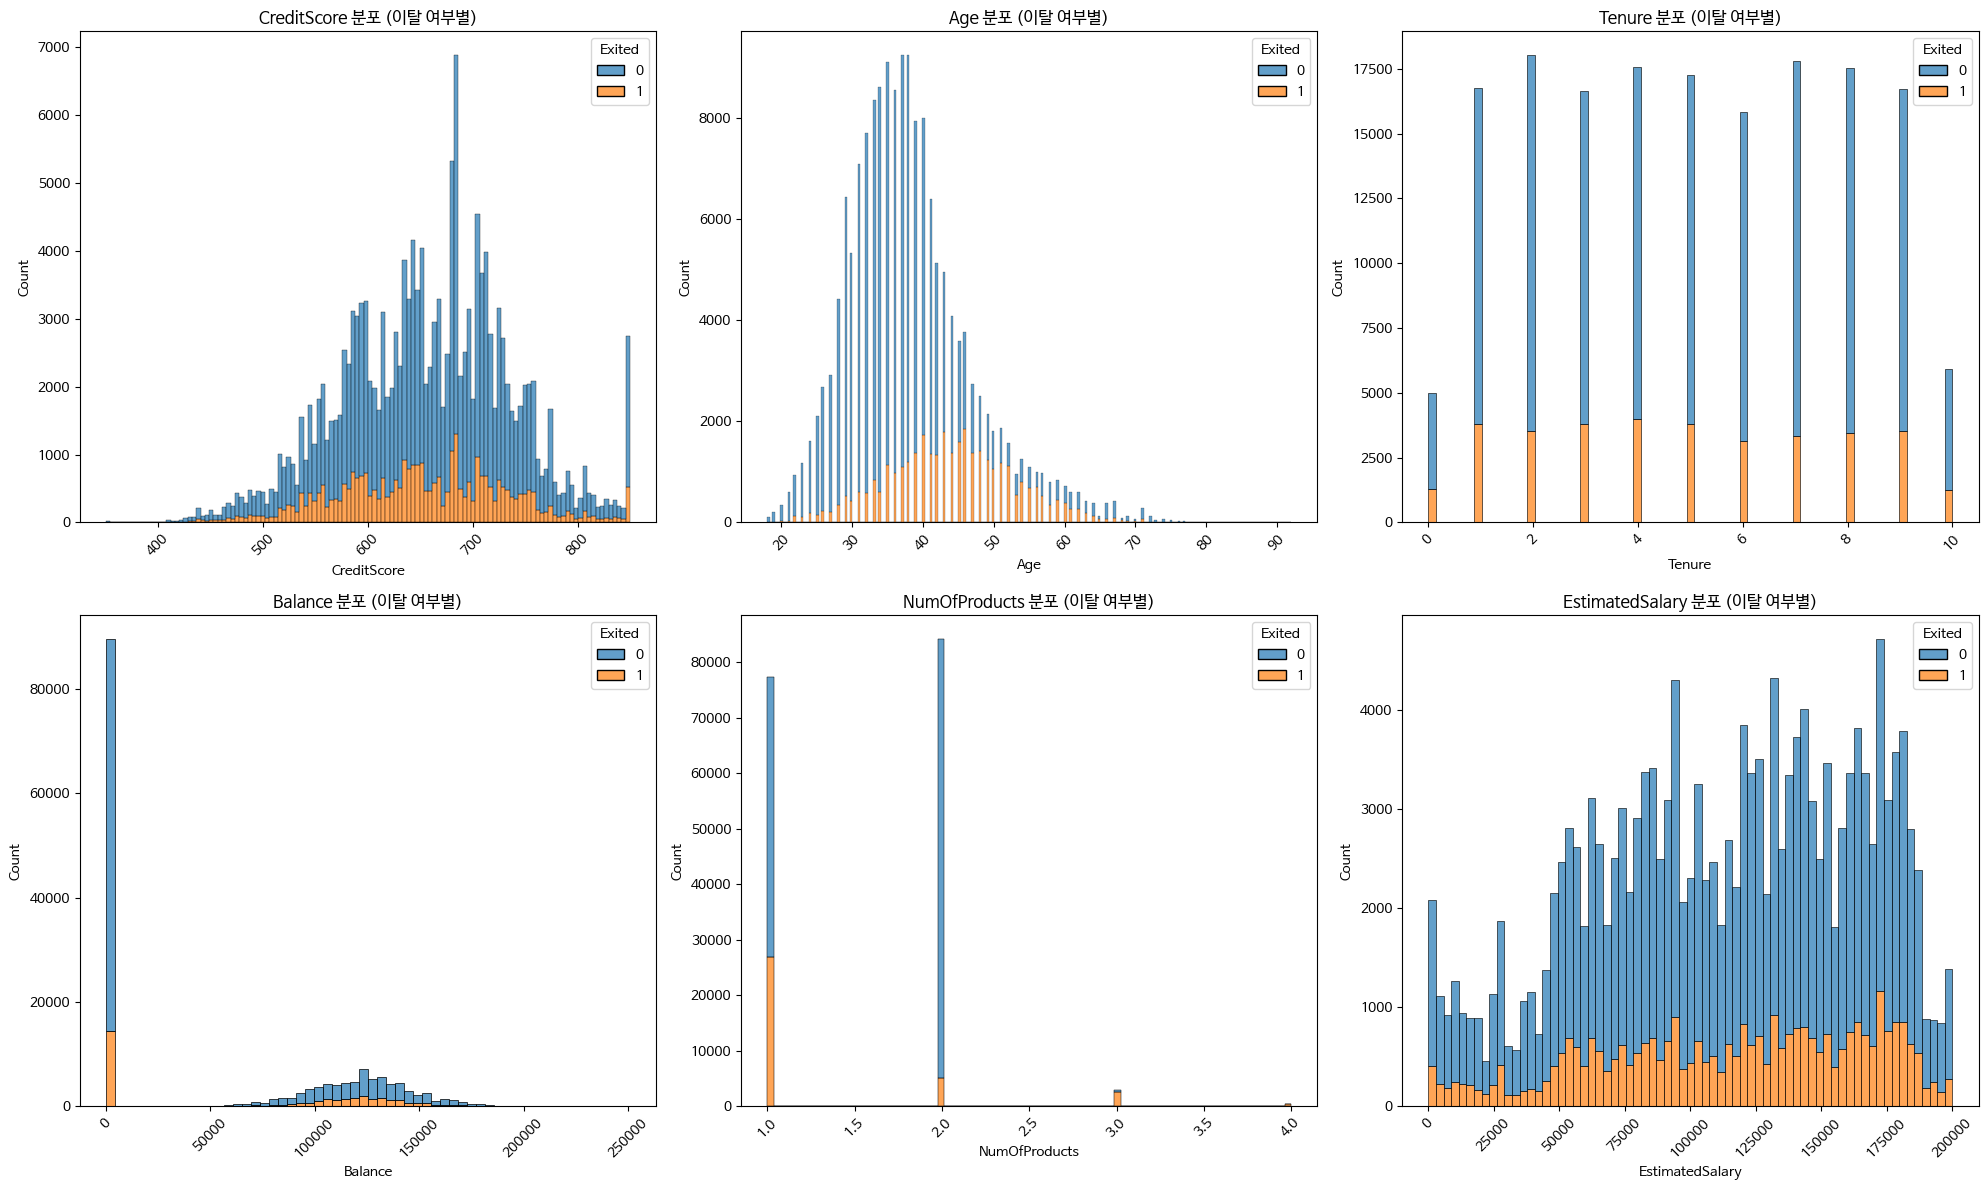


수치형 변수 기초 통계:
       CreditScore                                                    \
             count    mean    std    min    25%    50%    75%    max   
Exited                                                                 
0         130113.0  657.59  79.79  350.0  599.0  662.0  711.0  850.0   
1          34921.0  652.22  81.14  350.0  593.0  651.0  708.0  850.0   

             Age         ... NumOfProducts      EstimatedSalary             \
           count   mean  ...           75%  max           count       mean   
Exited                   ...                                                 
0       130113.0  36.56  ...           2.0  4.0        130113.0  112084.29   
1        34921.0  43.96  ...           1.0  4.0         34921.0  114402.50   

                                                                    
             std    min       25%        50%        75%        max  
Exited                                                              
0       50214.66  11.58  7

In [7]:
# 2. 수치형 변수 분석
print(f"\n=== 수치형 변수 분석 ===")
numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

plt.figure(figsize=(20, 12))
for i, col in enumerate(numeric_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=train_data, x=col, hue='Exited', multiple='stack', alpha=0.7)
    plt.title(f'{col} 분포 (이탈 여부별)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 수치형 변수 기초 통계
print(f"\n수치형 변수 기초 통계:")
print(train_data[numeric_columns + ['Exited']].groupby('Exited').describe().round(2))


=== 범주형 변수 분석 ===

Geography별 이탈률:
  France: 16.5%
  Germany: 37.9%
  Spain: 17.2%

Gender별 이탈률:
  Female: 28.0%
  Male: 15.9%

HasCrCard별 이탈률:
  0.0: 22.7%
  1.0: 20.6%

IsActiveMember별 이탈률:
  0.0: 29.7%
  1.0: 12.5%


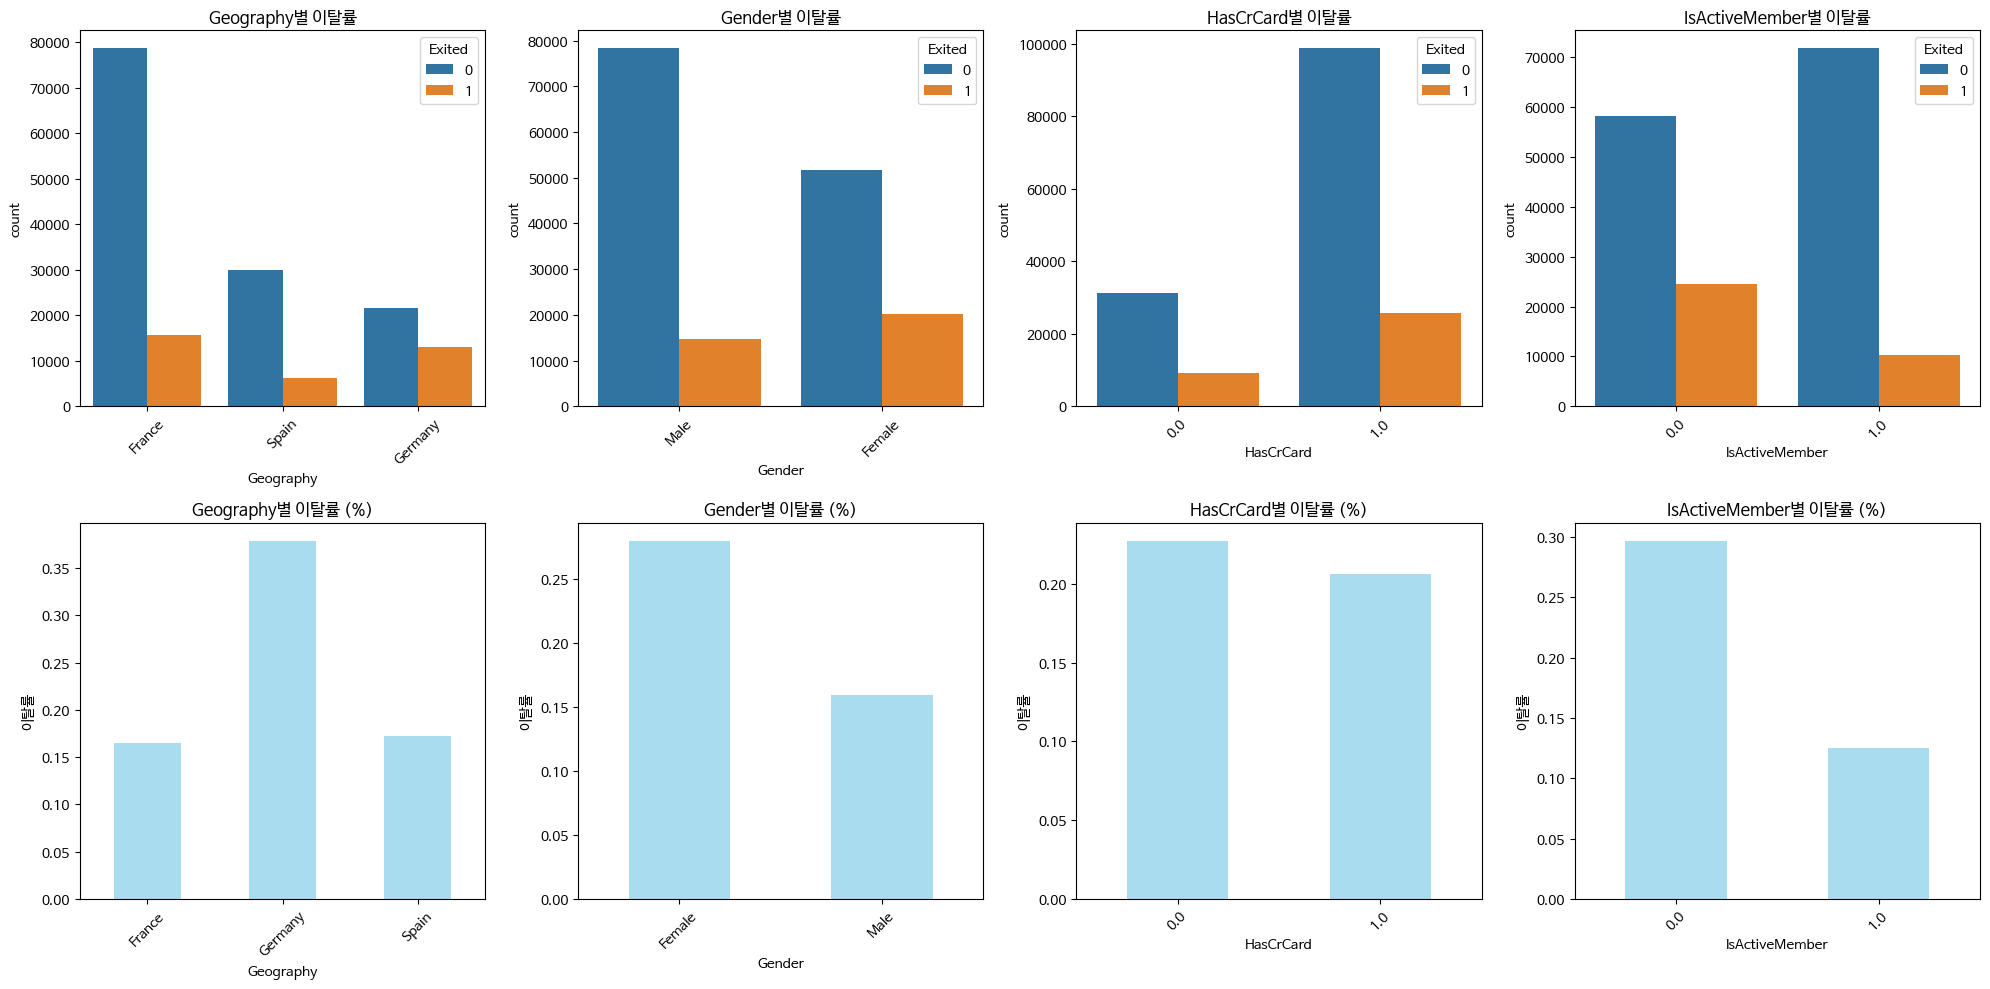

In [8]:
# 3. 범주형 변수 분석
print(f"\n=== 범주형 변수 분석 ===")
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

plt.figure(figsize=(20, 10))
for i, col in enumerate(categorical_columns):
    plt.subplot(2, 4, i+1)
    sns.countplot(data=train_data, x=col, hue='Exited')
    plt.title(f'{col}별 이탈률')
    plt.xticks(rotation=45)

    # 이탈률 계산
    plt.subplot(2, 4, i+5)
    churn_rate = train_data.groupby(col)['Exited'].mean()
    churn_rate.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title(f'{col}별 이탈률 (%)')
    plt.ylabel('이탈률')
    plt.xticks(rotation=45)

    # 수치로 출력
    print(f"\n{col}별 이탈률:")
    for category, rate in churn_rate.items():
        print(f"  {category}: {rate:.1%}")

plt.tight_layout()
plt.show()


=== 상관관계 분석 ===


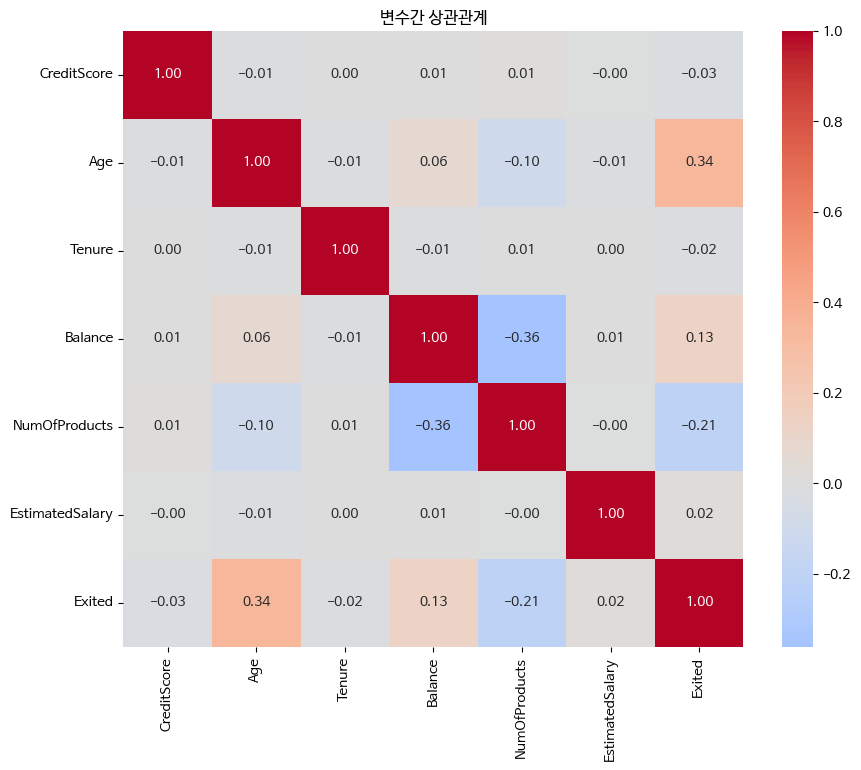

타겟과의 상관관계 (절댓값 기준 정렬):
  Age: 0.341
  NumOfProducts: -0.215
  Balance: 0.130
  CreditScore: -0.027
  Tenure: -0.020
  EstimatedSalary: 0.019


In [9]:
# 4. 상관관계 분석
print(f"\n=== 상관관계 분석 ===")
# 수치형 변수만으로 상관관계 계산
correlation_data = train_data[numeric_columns + ['Exited']].copy()

plt.figure(figsize=(10, 8))
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('변수간 상관관계')
plt.show()

print("타겟과의 상관관계 (절댓값 기준 정렬):")
target_corr = correlation_matrix['Exited'].abs().sort_values(ascending=False)
for var, corr in target_corr.items():
    if var != 'Exited':
        print(f"  {var}: {correlation_matrix['Exited'][var]:.3f}")

### 5. 주요 인사이트 정리
1. 클래스 불균형: 약 79% 잔류, 21% 이탈
2. 지역별 이탈률 차이 존재
3. 나이와 이탈 간 상관관계 존재
4. 상품 개수와 이탈률 사이 관련성 존재
5. 활성 멤버 여부가 이탈에 큰 영향을 미침

In [11]:
# 데이터 전처리
def prepare_data(df, is_train=True, scaler=None):
    """개선된 데이터 전처리 함수"""
    df_processed = df.copy()

    # 1. 불필요한 컬럼 제거
    if is_train:
        X = df_processed.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)
        y = df_processed['Exited']
    else:
        X = df_processed.drop(['id', 'CustomerId', 'Surname'], axis=1)
        y = None

    # 2. 범주형 변수 One-Hot Encoding
    categorical_cols = ['Geography', 'Gender']
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

    # 3. 스케일링 (수치형 변수만)
    numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

    if scaler is None:
        scaler = StandardScaler()
        X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])
    else:
        X_encoded[numeric_cols] = scaler.transform(X_encoded[numeric_cols])

    if is_train:
        return X_encoded, y, scaler
    else:
        return X_encoded, scaler

# 전처리 적용
X, y, scaler = prepare_data(train_data, is_train=True)

print(f"전처리 후 특성 수: {X.shape[1]}")
print(f"전처리 후 데이터 크기: {X.shape}")

전처리 후 특성 수: 13
전처리 후 데이터 크기: (165034, 13)


In [22]:
# ===== 모델 비교 시작 =====

# 성능 저장용 dict
results = {}

def evaluate_model(model, X_val, y_val, model_name):
    """모델 성능 평가 함수"""
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    results[model_name] = {
        'accuracy': accuracy,
        'auc': auc,
        'recall_class1': sensitivity,
        'precision_class1': precision,
        'specificity': specificity,
        'confusion_matrix': cm
    }

    print(f"\n=== {model_name} 성능 ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"이탈고객 탐지율 (Recall): {sensitivity:.4f}")
    print(f"이탈고객 정밀도 (Precision): {precision:.4f}")
    print(f"잔류고객 정확도 (Specificity): {specificity:.4f}")

    return results[model_name]

In [23]:
# 1. 로지스틱 회귀
print("1. 로지스틱 회귀")
lr_basic = LogisticRegression(random_state=42, max_iter=1000)
lr_basic.fit(X_train, y_train)
evaluate_model(lr_basic, X_val, y_val, "LogisticRegression")


1. 로지스틱 회귀

=== LogisticRegression 성능 ===
Accuracy: 0.8335
AUC: 0.8145
이탈고객 탐지율 (Recall): 0.3814
이탈고객 정밀도 (Precision): 0.6937
잔류고객 정확도 (Specificity): 0.9548


{'accuracy': 0.8334898657860453,
 'auc': np.float64(0.8144881329975128),
 'recall_class1': np.float64(0.38144329896907214),
 'precision_class1': np.float64(0.69375),
 'specificity': np.float64(0.9548092072397495),
 'confusion_matrix': array([[24847,  1176],
        [ 4320,  2664]])}

In [24]:
# 2. XGBoost
print("2. XGBoost")
xgb_basic = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_basic.fit(X_train, y_train)
evaluate_model(xgb_basic, X_val, y_val, "XGBoost")

2. XGBoost

=== XGBoost 성능 ===
Accuracy: 0.8647
AUC: 0.8875
이탈고객 탐지율 (Recall): 0.5593
이탈고객 정밀도 (Precision): 0.7377
잔류고객 정확도 (Specificity): 0.9466


{'accuracy': 0.8646650710455358,
 'auc': np.float64(0.8874780164071091),
 'recall_class1': np.float64(0.5592783505154639),
 'precision_class1': np.float64(0.7376770538243627),
 'specificity': np.float64(0.9466241401836837),
 'confusion_matrix': array([[24634,  1389],
        [ 3078,  3906]])}


전체 성능 비교:
                    accuracy       auc recall_class1 precision_class1  \
LogisticRegression   0.83349  0.814488      0.381443          0.69375   
XGBoost             0.864665  0.887478      0.559278         0.737677   

                   specificity  
LogisticRegression    0.954809  
XGBoost               0.946624  


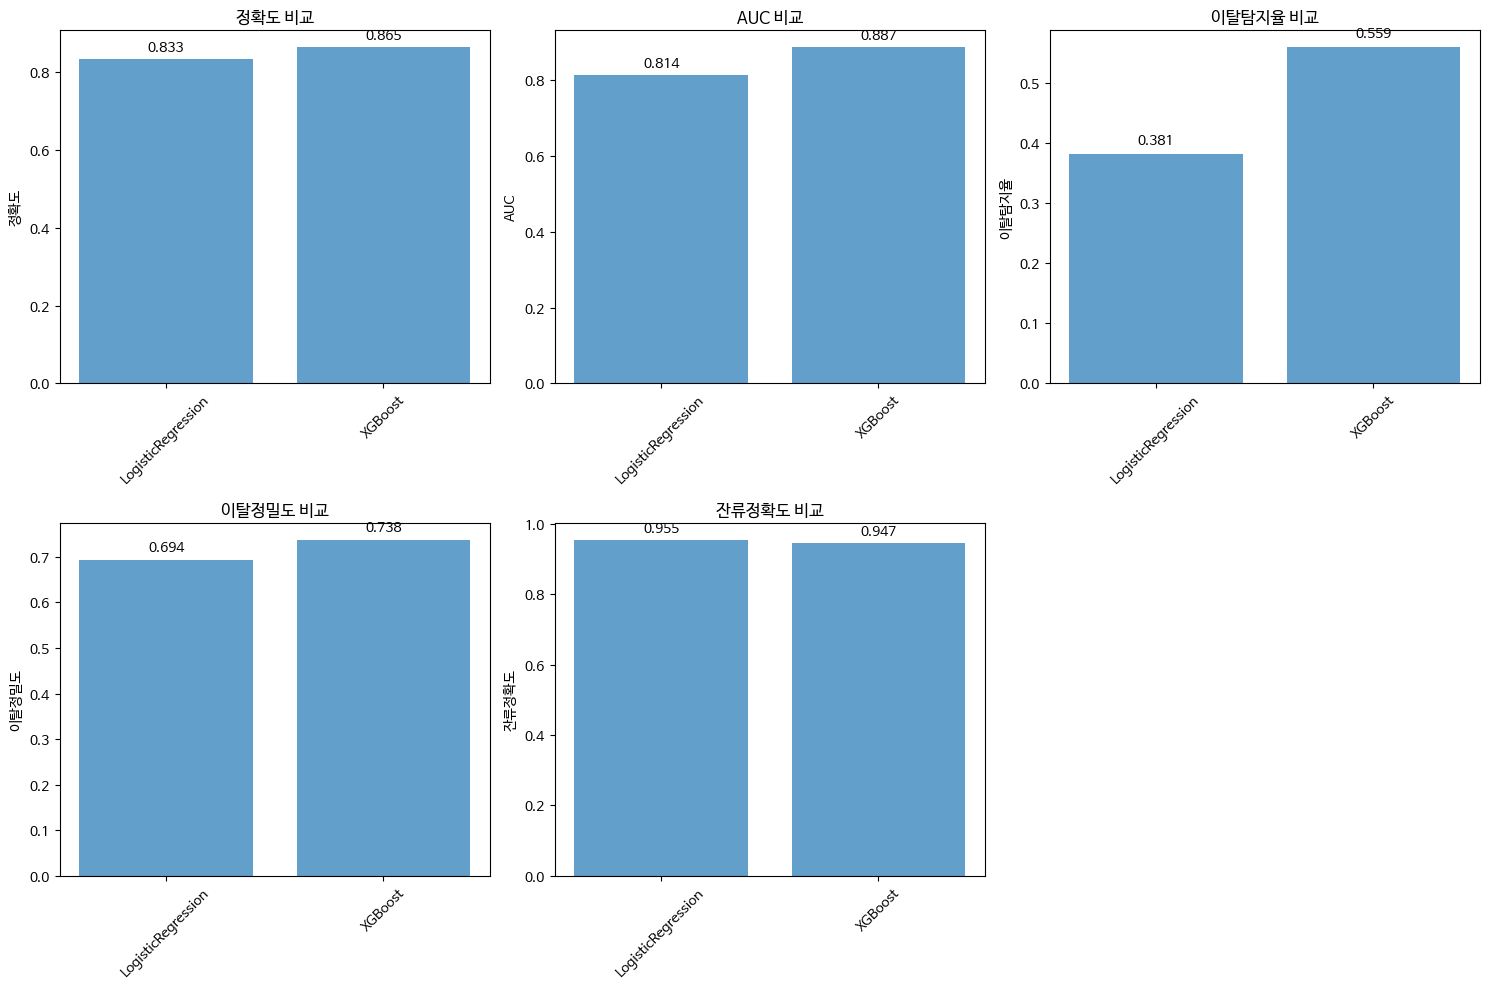

In [25]:
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("\n전체 성능 비교:")
print(comparison_df[['accuracy', 'auc', 'recall_class1', 'precision_class1', 'specificity']])

# 시각화
plt.figure(figsize=(15, 10))

metrics = ['accuracy', 'auc', 'recall_class1', 'precision_class1', 'specificity']
metric_names = ['정확도', 'AUC', '이탈탐지율', '이탈정밀도', '잔류정확도']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    plt.subplot(2, 3, i+1)
    values = comparison_df[metric]
    bars = plt.bar(range(len(values)), values, alpha=0.7)
    plt.title(f'{name} 비교')
    plt.ylabel(name)
    plt.xticks(range(len(values)), [model.replace('_', '\n') for model in values.index], rotation=45)

    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()